# Exercise 2

Please note that all gradients and hessians have been computed using the [Symbolic Math Toolbox](https://www.mathworks.com/products/symbolic.html). This was done to avoid the usage of SymPy as it is easier to use MATLAB for this purpose. Steps to find gradient and hessian using MATLAB - 
1. Define the function using symbolic variables
2. Find and print the gradient using the inbuilt [gradient function](https://www.mathworks.com/help/symbolic/sym.gradient.html). Recreate the same function in python syntax for our purpose.
3. Find and print the hessian using the inbuilt [hessian function](https://www.mathworks.com/help/symbolic/sym.hessian.html). Recreate the same function in python syntax for our purpose.

The default number of iterations have been chosen to be $1000$ and the tolerance as $10^{-4}$ (took these value from [examples](https://gepettoweb.laas.fr/doc/stack-of-tasks/pinocchio/devel/doxygen-html/md_doc_b-examples_i-inverse-kinematics.html) seen in Pinocchio Documentation). The default $\alpha$ has been chosen to be $10^{-1}$. These parameters have been changed based on the problem.

In [73]:
# Import Necessary Libraries
import numpy as np
import matplotlib.pyplot as plt

### Let us create a function to check for positive definiteness using Cholesky Decomposition as we shall be using this later

In [74]:
def is_positive_definite(matrix):
    """Check if a matrix is positive definite using Cholesky decomposition.

    Args:
        matrix (np.array): The matrix to check.

    Returns:
        bool: True if the matrix is positive definite, False otherwise.
    """
    try:
        # Attempt Cholesky decomposition
        np.linalg.cholesky(matrix)
        return True
    except np.linalg.LinAlgError:
        return False

## Now we shalll create a function for Gradient Descent Without Backtracking

We shall use the simple formula shown in lecture 4. The criteria for convergence will be the first order necessary condition, i.e., if $||\nabla f(x^*)|| = 0$.

<img src='gradient_descent.png' width="500">

In [75]:
def gd_wo_bls(f, f_grad, x0, max_iter=1000, tol=1e-4, alpha=0.001):
    """
    Gradient Descent Without Backtracking Line Search (BLS) to find the local minimum of a function.

    This function minimizes the input function `f` using its gradient `f_grad` and an initial guess `x0`.
    It does not use backtracking line search (BLS) and instead uses a fixed step size `alpha`.

    Args:
        f (callable): The function to be minimized. It should take a vector as input and return a scalar.
        f_grad (callable): The gradient of the function `f`. It should take a vector as input and return a vector.
        x0 (array-like): The initial guess for the minimum, a vector of the same dimensions as the input of `f`.
        max_iter (int, optional): The maximum number of iterations to perform. Defaults to 1000.
        tol (float, optional): The tolerance for convergence. The algorithm stops if the norm of the gradient
                               is below this value. Defaults to 1e-4.
        alpha (float, optional): The step size (learning rate) for each gradient update. Defaults to 0.001.

    Returns:
        None: The function outputs the computed optimum and plots the convergence graph.
    """

    # Initialize x_i with the initial guess
    x_i = x0

    # List to store each value of x during iterations for plotting and analysis
    x_values = [x_i]

    # Perform Gradient Descent to find the optimum
    for i in range(1, max_iter):
        grad = f_grad(x_i)  # Compute the gradient at the current x_i

        # Update x_i by taking a step opposite to the gradient direction
        x_new = x_i - alpha * grad

        # Store the new value of x for plotting later
        x_values.append(x_new)

        # Check for convergence: if the norm of the gradient is below the tolerance
        if np.linalg.norm(grad) < tol:
            print(f"Converged in {i} iterations.")
            x_i = x_new  # Update x_i to the latest value before breaking
            break

        # Update x_i for the next iteration
        x_i = x_new
    else:
        # This block executes if the loop did not break, indicating no convergence within max_iter
        print("Did not converge within the maximum number of iterations.")

    # The computed optimum is the last value of x
    computed_optimum = x_values[-1]

    # Compute the distances from each x value in the iteration history to the computed optimum
    distance_history = [np.linalg.norm(x - computed_optimum) for x in x_values]

    # Output the results
    print(f"Computed optimum using gradient descent: {computed_optimum}")
    print(f"f(x) at computed optimum: {f(computed_optimum)}")

    # Plotting the convergence of the algorithm
    plt.figure(figsize=(10, 6))
    plt.plot(distance_history, label='Distance to Computed Optimum', color='blue')
    plt.title('Convergence of Gradient Descent')
    plt.xlabel('Iteration')
    plt.ylabel('Distance to Computed Optimum')
    plt.grid(True)
    plt.legend()
    plt.show()

## Now we shall create a function for Gradient Descent with backtracking line search

We shall use the backtracking algorithm explained in lecture 4 with $p_k$ = $-\nabla f(x)$. The criteria for convergence of $f(x)$ will be the same as the previous one. 

The criteria for the convergence of $\alpha$ will be as per the algorithm shown in lecture 4 - 

<img src='backtracking_line_search_algo.png' width="500">

In [76]:
def gd_w_bls(f, f_grad, x0, max_iter=1000, tol=1e-4, alpha_init=0.1, rho=0.01):
    """
    Gradient Descent with Backtracking Line Search (BLS) to find the local minimum of a function.

    This function minimizes the input function `f` using its gradient `f_grad` and an initial guess `x0`.
    It uses backtracking line search to adjust the step size (`alpha`) dynamically for faster and more efficient convergence.

    Args:
        f (callable): The function to be minimized. It should take a vector as input and return a scalar.
        f_grad (callable): The gradient of the function `f`. It should take a vector as input and return a vector.
        x0 (array-like): The initial guess for the minimum, a vector of the same dimensions as the input of `f`.
        max_iter (int, optional): The maximum number of iterations to perform. Defaults to 1000.
        tol (float, optional): The tolerance for convergence. The algorithm stops if the norm of the gradient
                               is below this value. Defaults to 1e-4.
        alpha_init (float, optional): The initial step size for the gradient update. Defaults to 0.1.
        rho (float, optional): The reduction factor for the step size in the backtracking line search. Defaults to 0.01.

    Returns:
        None: The function outputs the computed optimum, final step size, and plots convergence graphs.
    """

    c = 1e-4  # Parameter for the backtracking line search condition

    # Initialize x_i with the initial guess
    x_i = x0

    # List to store each value of x and alpha during iterations
    x_values = [x_i]
    alpha_history = [alpha_init]

    # Perform Gradient Descent to find the optimum
    for i in range(1, max_iter):
        grad = f_grad(x_i)  # Compute the gradient at the current x_i
        # Direction is the negative gradient (steepest descent)
        p_k = -grad

        # Backtracking Line Search to determine the step size (alpha)
        alpha = alpha_init
        while f(x_i + alpha * p_k) > f(x_i) + c * alpha * np.dot(grad, p_k):
            alpha *= rho  # Reduce alpha by the factor rho until the condition is satisfied

        alpha_history.append(alpha)  # Record the value of alpha for analysis

        # Update x_i by taking a step in the direction of the negative gradient
        x_new = x_i - alpha * grad

        # Store the new value of x for plotting later
        x_values.append(x_new)

        # Check for convergence: if the norm of the gradient is below the tolerance
        if np.linalg.norm(f_grad(x_new)) < tol:
            print(f"Converged in {i} iterations.")
            x_i = x_new  # Update x_i to the latest value before breaking
            break

        # Update x_i for the next iteration
        x_i = x_new
    else:
        # This block executes if the loop did not break, indicating no convergence within max_iter
        print("Did not converge within the maximum number of iterations.")

    # The computed optimum is the last value of x
    computed_optimum = x_values[-1]

    # Compute the distances from each x value in the iteration history to the computed optimum
    distance_history = [np.linalg.norm(x - computed_optimum) for x in x_values]

    # Output the results
    print(f"Computed optimum using gradient descent: {computed_optimum}")
    print(f"f(x) at computed optimum: {f(computed_optimum)}")
    print(f"Final value of alpha = {alpha_history[-1]}")

    # Plotting the results as subplots
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))

    # Subplot 1: Convergence of the distance to the computed optimum
    axs[0].plot(distance_history,
                label='Distance to Computed Optimum', color='blue')
    axs[0].set_title(
        'Convergence of Gradient Descent with Backtracking Line Search')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Distance to Computed Optimum')
    axs[0].grid(True)
    axs[0].legend()

    # Subplot 2: Value of alpha in the backtracking line search
    axs[1].plot(alpha_history, label='Alpha (Step Size)', color='green')
    axs[1].set_title('Value of Alpha in Backtracking Line Search')
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Alpha (Step Size)')
    axs[1].grid(True)
    axs[1].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

## Now we shall create a function for Newton's method with backtracking line search

We shall implement the same backtracking line search algorithm as shown above. But in this case, $p_k = - \frac{\nabla f(x)}{\nabla ^2 f(x) }$. 

And, we shall implement the method as shown in lecture 4 - 

<img src='newtons_method.png' width="500">

The criteria for convergence remains the same.

In [77]:
def nm_w_bls(f, f_grad, f_hess, x0, max_iter=1000, tol=1e-4, alpha_init=0.001, rho=0.1, gamma=0):
    """
    Newton's Method with Backtracking Line Search (BLS) to find the local minimum of a function.

    This function minimizes the input function `f` using its gradient `f_grad`, its Hessian `f_hess`,
    and an initial guess `x0`. It uses Newton's method with backtracking line search to dynamically adjust
    the step size (`alpha`). It also handles cases where the Hessian is not positive definite by applying 
    regularization with a parameter `gamma`.

    Args:
        f (callable): The function to be minimized. It should take a vector as input and return a scalar.
        f_grad (callable): The gradient of the function `f`. It should take a vector as input and return a vector.
        f_hess (callable): The Hessian (second derivative) of the function `f`. It should take a vector as input and return a matrix.
        x0 (array-like): The initial guess for the minimum, a vector of the same dimensions as the input of `f`.
        max_iter (int, optional): The maximum number of iterations to perform. Defaults to 1000.
        tol (float, optional): The tolerance for convergence. The algorithm stops if the norm of the gradient
                               is below this value. Defaults to 1e-4.
        alpha_init (float, optional): The initial step size for the Newton update. Defaults to 0.001.
        rho (float, optional): The reduction factor for the step size in the backtracking line search. Defaults to 0.1.
        gamma (float, optional): The regularization parameter to handle cases when the Hessian is not positive definite. Defaults to 0.

    Returns:
        None: The function outputs the computed optimum, final step size, and plots convergence graphs.
    """

    c = 1e-4  # Parameter for the backtracking line search condition

    # Initialize x_i with the initial guess
    x_i = x0

    # Lists to store the values of x and alpha during iterations
    x_values = [x_i]
    alpha_history = []

    # Perform Newton's Method with Backtracking Line Search to find the optimum
    for i in range(1, max_iter + 1):
        grad = f_grad(x_i)  # Compute the gradient at the current x_i
        hess = f_hess(x_i)  # Compute the Hessian at the current x_i

        # Determine the direction based on the Hessian's properties
        if isinstance(x_i, np.ndarray):
            if is_positive_definite(hess):
                # Solve for p_k when Hessian is positive definite
                p_k = np.linalg.solve(hess, -grad)
            else:
                # Apply regularization when Hessian is not positive definite
                p_k = np.linalg.solve(
                    hess + gamma * np.eye(hess.shape[0]), -grad)
        else:
            # Handle the scalar case for x_i (1-dimensional input)
            if hess < 0:
                # Apply regularization if the Hessian (second derivative) is negative
                p_k = -(grad / (hess + gamma))
            else:
                # Use the unmodified Hessian if it's positive
                p_k = -(grad / hess)

        # Backtracking Line Search to determine the step size alpha
        alpha = alpha_init
        while f(x_i + alpha * p_k) > f(x_i) + c * alpha * np.dot(grad, p_k):
            alpha *= rho  # Reduce alpha by factor rho until the condition is satisfied

        alpha_history.append(alpha)  # Record the value of alpha

        # Update x_i using the determined step size
        x_new = x_i + alpha * p_k

        # Store the new value of x for plotting later
        x_values.append(x_new)

        # Check for convergence: if the norm of the gradient is below the tolerance
        if np.linalg.norm(f_grad(x_new)) < tol:
            print(f"Converged in {i} iterations.")
            x_i = x_new  # Update x_i to the latest value before breaking
            break

        # Update x_i for the next iteration
        x_i = x_new
    else:
        # This block executes if the loop did not break, indicating no convergence within max_iter
        print("Did not converge within the maximum number of iterations.")

    # The computed optimum is the last value of x
    computed_optimum = x_values[-1]

    # Compute the distances from each x value in the iteration history to the computed optimum
    distance_history = [np.linalg.norm(x - computed_optimum) for x in x_values]

    # Output the results
    print(f"Computed optimum using Newton's method: {computed_optimum}")
    print(f"f(x) at computed optimum: {f(computed_optimum)}")
    print(f"Final value of alpha = {alpha_history[-1]}")

    # Plotting the results as subplots
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))

    # Subplot 1: Convergence of the distance to the computed optimum
    axs[0].plot(distance_history,
                label='Distance to Computed Optimum', color='blue')
    axs[0].set_title(
        'Convergence of Newton\'s Method with Backtracking Line Search')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Distance to Computed Optimum')
    axs[0].grid(True)
    axs[0].legend()

    # Subplot 2: Value of alpha in the backtracking line search
    axs[1].plot(alpha_history, label='Alpha (Step Size)', color='green')
    axs[1].set_title('Value of Alpha in Backtracking Line Search')
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Alpha (Step Size)')
    axs[1].grid(True)
    axs[1].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

## Ex 2.1) $$\begin{equation} \notag f(x) = -e^{-(x-1)^2}, \quad \text{starting with } x_0 = 0\end{equation}$$

For this function, the hessian is not positive definite, so a small gamma has been added to it to make it positive semidefinite.

Converged in 50 iterations.
Computed optimum using gradient descent: 0.9999663708173457
f(x) at computed optimum: -0.9999999988690781


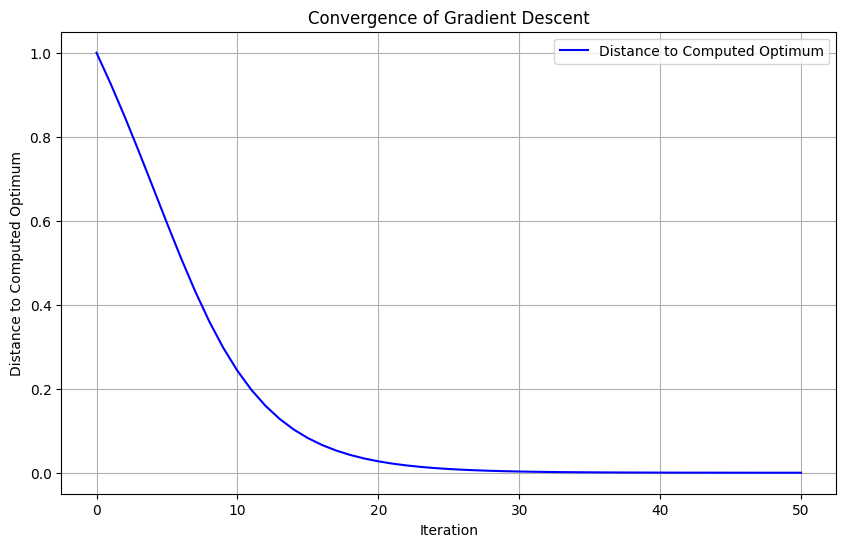

Converged in 2545 iterations.
Computed optimum using gradient descent: 1.0000463797067505
f(x) at computed optimum: -0.9999999978489228
Final value of alpha = 0.05


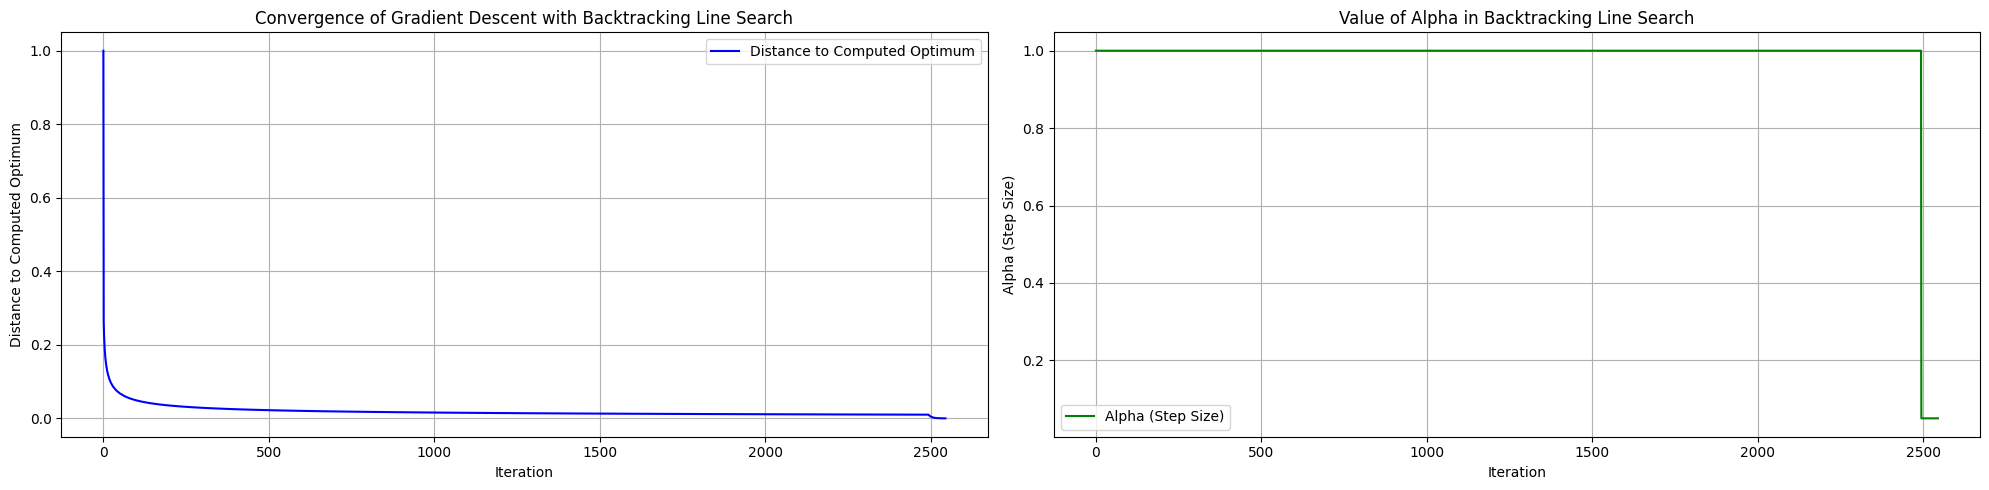

Converged in 8 iterations.
Computed optimum using Newton's method: 0.9999865774072785
f(x) at computed optimum: -0.999999999819834
Final value of alpha = 1.25


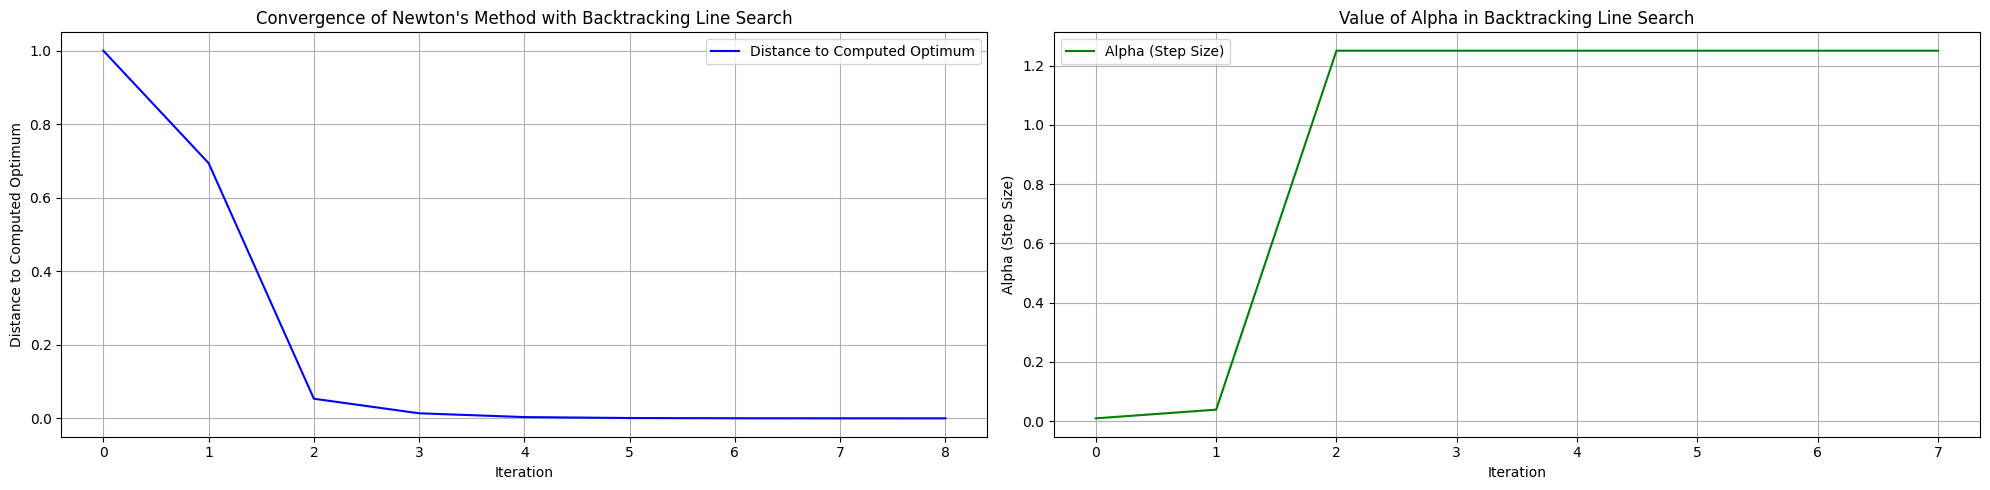

In [78]:
def f1(x):
    """Objective function f(x) = -exp(-((x - 1)^2))"""
    return -np.exp(-((x - 1)**2))


def f1_gradient(x):
    """Gradient of the objective function f(x)"""
    return 2 * (x - 1) * np.exp(-((x - 1)**2))


def f1_hessian(x):
    """Hessian of the objective function f(x)"""
    return (2 * np.exp(-((x - 1)**2)) - np.exp(-((x - 1)**2)) * (2 * x - 2)**2)


# Call the function to compute the local minima using Gradient Descent Without Backtracking Line Search and Plot
gd_wo_bls(f=f1, f_grad=f1_gradient, x0=0, alpha=0.1)

# Call the function to compute the local minima using Gradient Descent With Backtracking Line Search and Plot
gd_w_bls(f=f1, f_grad=f1_gradient, x0=0,
         alpha_init=1, rho=0.05, max_iter=3000)

# Call the function to compute the local minima using Newton's Method With Backtracking Line Search and Plot
nm_w_bls(f=f1, f_grad=f1_gradient, f_hess=f1_hessian,
         x0=0, alpha_init=5, rho=0.5, gamma=74e-2)

## Ex 2.2) $$\begin{equation}\notag f(x) = (1 - x)^2 + 100(y - x^2)^2, \quad \text{starting with } x_0 = y_0 = 1.2\end{equation}$$

For this case, the hessian is not postive semidefinite, due to which a small gamma has been added to it for regularisation.

Converged in 17743 iterations.
Computed optimum using gradient descent: [1.00011176 1.00022397]
f(x) at computed optimum: 1.2509199606097599e-08


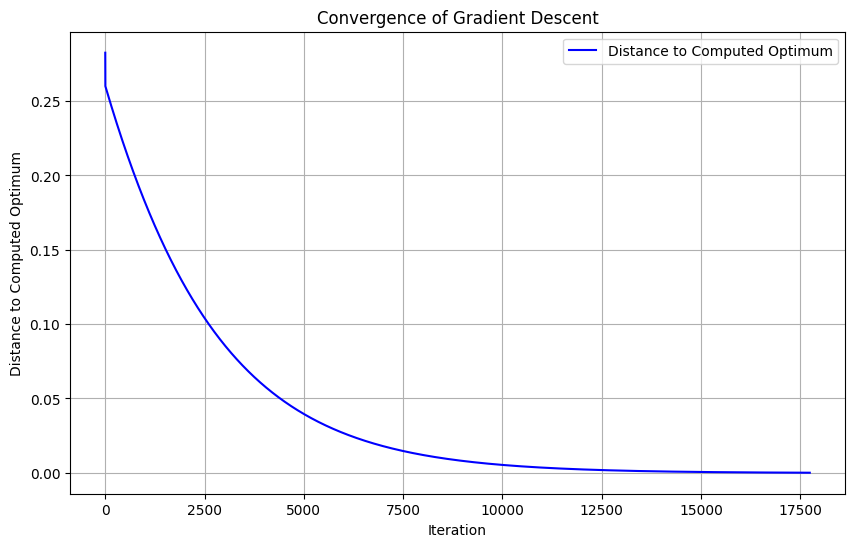

Converged in 2962 iterations.
Computed optimum using gradient descent: [1.00010986 1.00022021]
f(x) at computed optimum: 1.2091503930311872e-08
Final value of alpha = 0.0007500000000000002


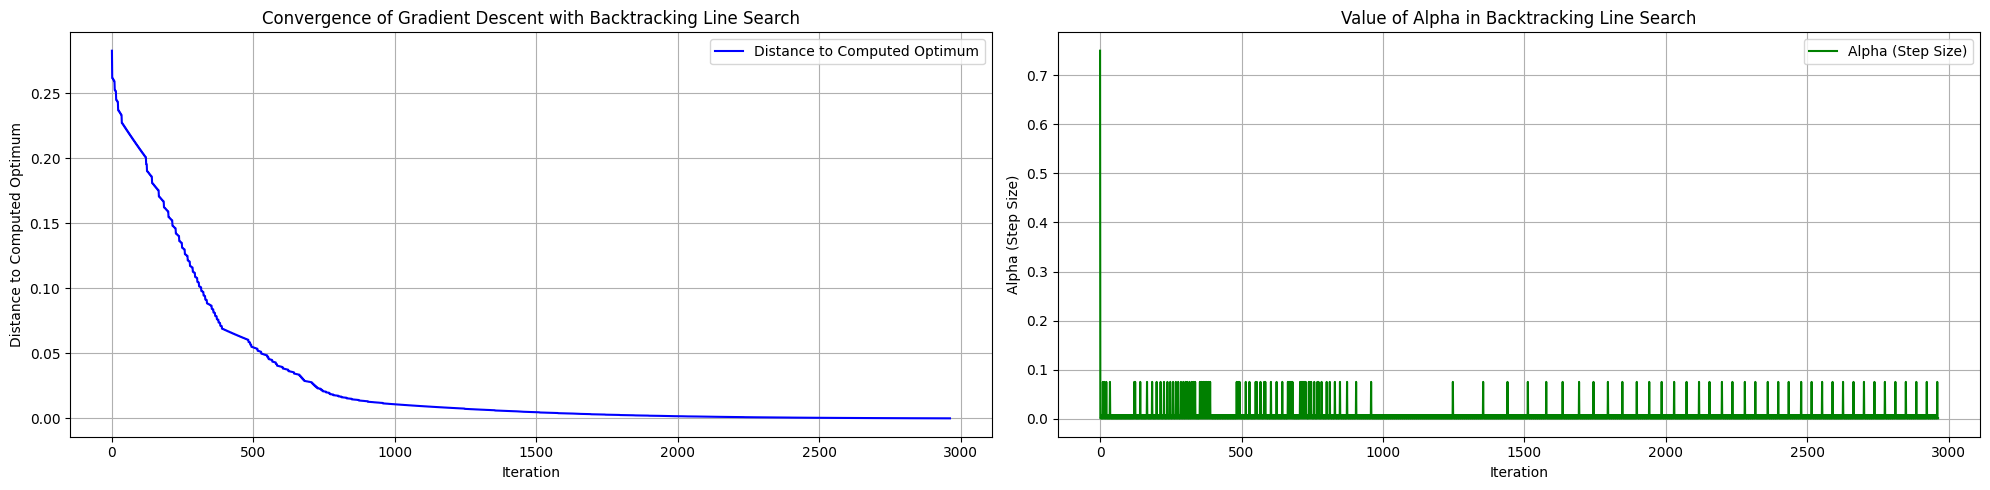

Converged in 47 iterations.
Computed optimum using Newton's method: [0.99999996 1.0000001 ]
f(x) at computed optimum: 3.3306507411448257e-12
Final value of alpha = 0.25


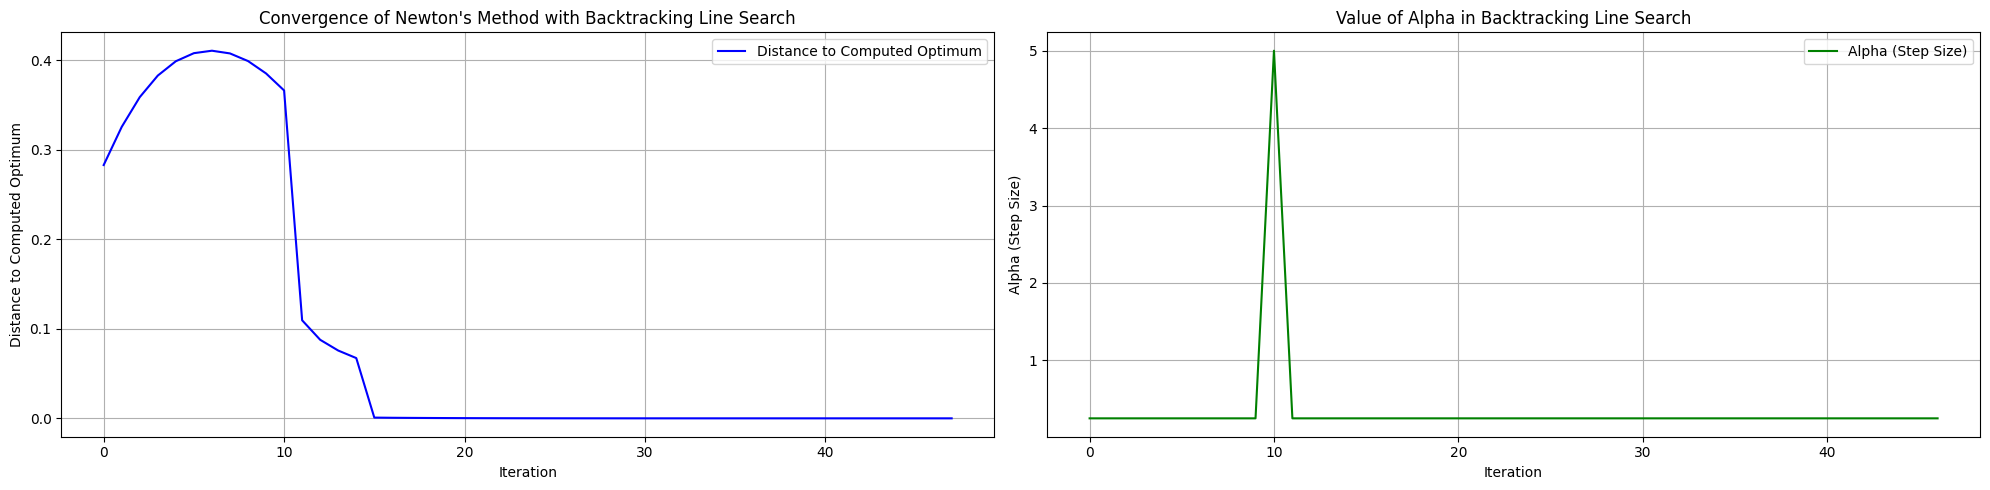

In [79]:
def f2(x):
    """Rosenbrock function (1 - x)^2 + 100 * (y - x^2)^2"""
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2


def f2_gradient(x):
    """Gradient of the Rosenbrock function"""
    df_dx = 2 * x[0] - 400 * x[0] * (-x[0]**2 + x[1]) - 2
    df_dy = -200 * x[0]**2 + 200 * x[1]
    return np.array([df_dx, df_dy])


def f2_hessian(x):
    """Hessian of the Rosenbrock function"""
    d2f_dx2 = 1200 * x[0]**2 - 400 * x[1] + 2
    d2f_dxdy = -400 * x[0]
    d2f_dydx = -400 * x[0]
    d2f_dy2 = 200
    return np.array([[d2f_dx2, d2f_dxdy], [d2f_dydx, d2f_dy2]])


# Call the function to compute the local minima using Gradient Descent Without Backtracking Line Search and Plot
gd_wo_bls(f=f2, f_grad=f2_gradient, x0=np.array(
    [1.2, 1.2]), max_iter=20000, alpha=0.001)

# Call the function to compute the local minima using Gradient Descent With Backtracking Line Search and Plot
gd_w_bls(f=f2, f_grad=f2_gradient, x0=np.array(
    [1.2, 1.2]), max_iter=100000, alpha_init=0.75, rho=0.1)

# Call the function to compute the local minima using Newton's Method With Backtracking Line Search and Plot
nm_w_bls(f=f2, f_grad=f2_gradient, f_hess=f2_hessian, x0=np.array(
    [1.2, 1.2]), max_iter=100000, alpha_init=5, rho=0.05, gamma=(1 * np.eye(2)))

## Ex 2.3) $$\begin{equation}\notag f(x) = x^T \begin{bmatrix} 3 & 1 \\ 1 & 3 \end{bmatrix} x + \begin{bmatrix} -1 & 1 \end{bmatrix} x, \quad \text{starting with } x_0 = \begin{pmatrix} 10 \\ 10 \end{pmatrix}\end{equation}$$

Converged in 236 iterations.
Computed optimum using gradient descent: [ 0.24998366 -0.24998361]
f(x) at computed optimum: -0.249999998928568


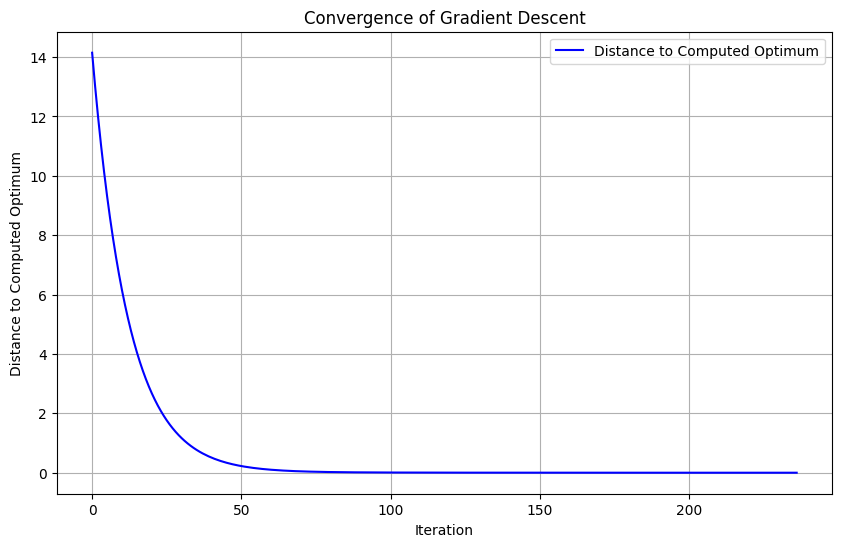

Converged in 59 iterations.
Computed optimum using gradient descent: [ 0.24998288 -0.24998287]
f(x) at computed optimum: -0.2499999988267964
Final value of alpha = 0.0375


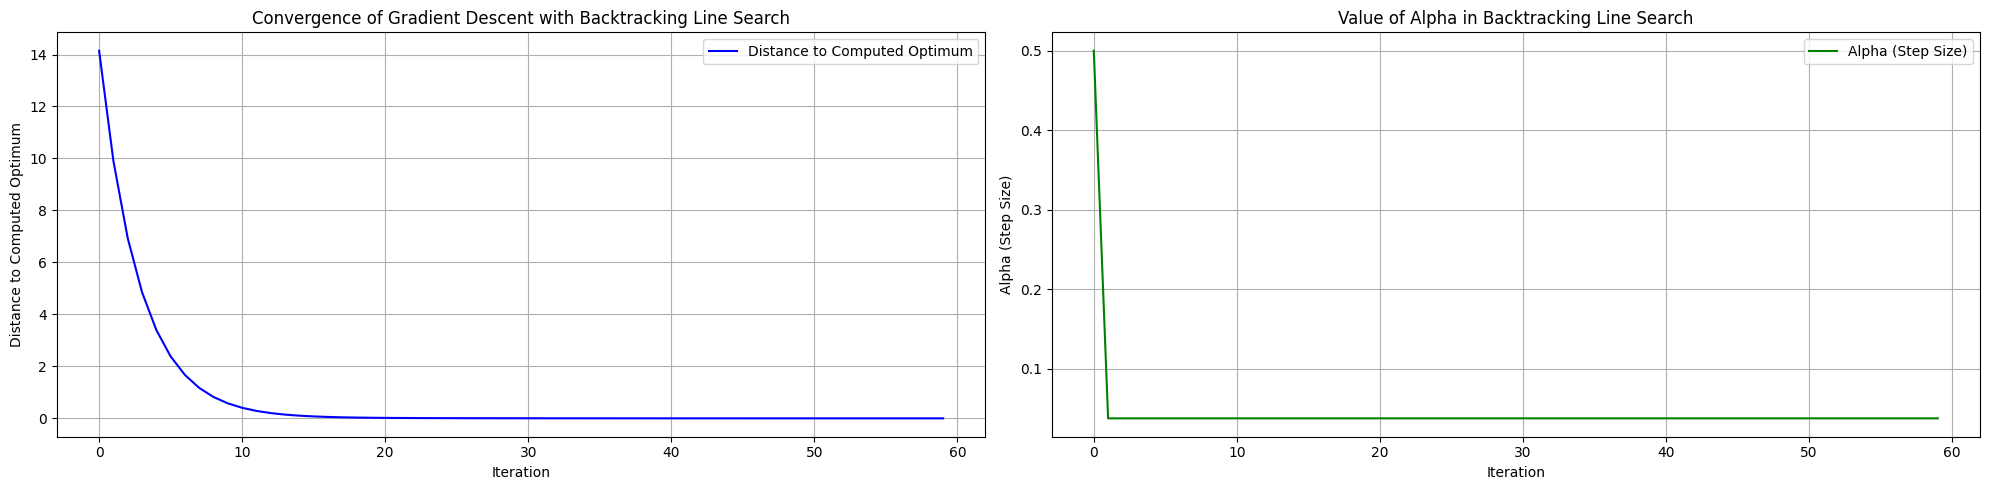

Converged in 1 iterations.
Computed optimum using Newton's method: [ 0.25 -0.25]
f(x) at computed optimum: -0.25
Final value of alpha = 1.0


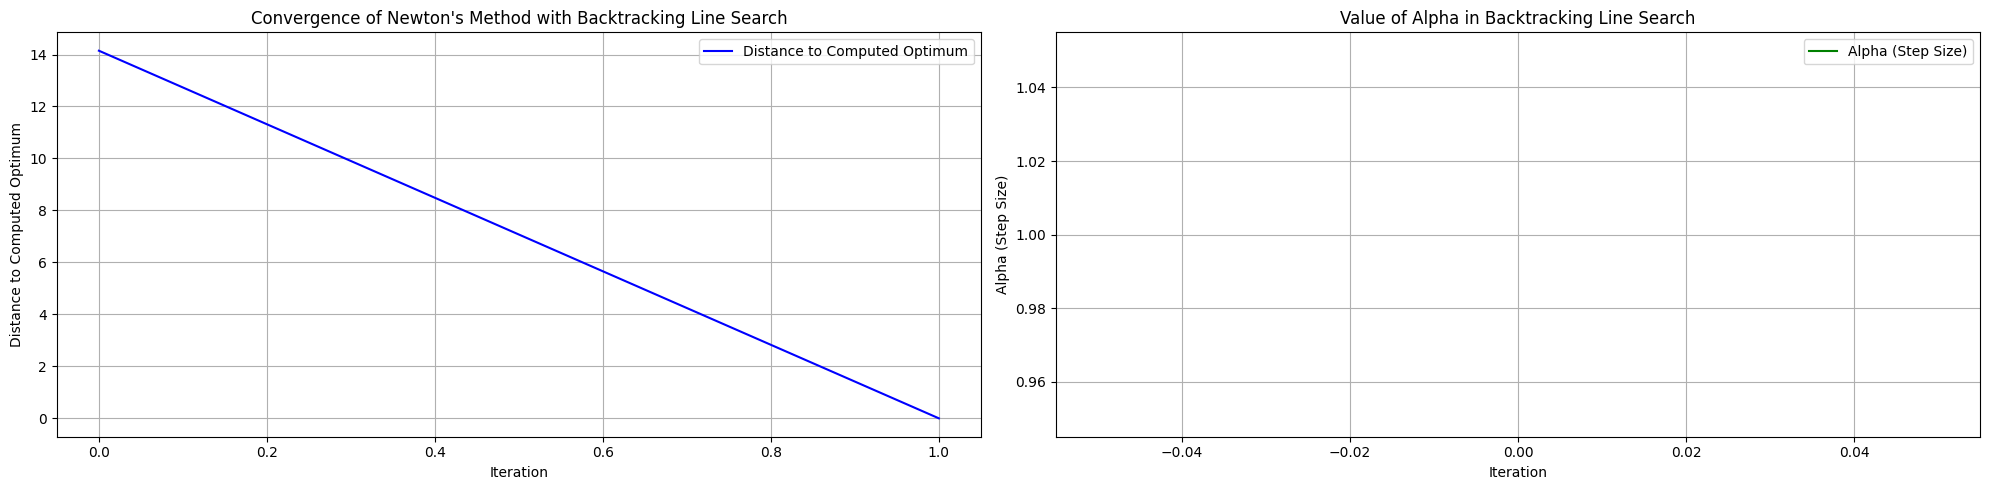

In [80]:
def f3(x):
    """Objective function f(x) = [x, y] * [3, 1; 1, 3] * [x; y] + [-1, 1] * [x; y]"""
    return x.T @ np.array([[3, 1], [1, 3]]) @ x + np.array([-1, 1]).T @ x


def f3_gradient(x):
    """Gradient of the objective function f(x)"""
    return np.array([6*x[0] + 2*x[1] - 1, 2*x[0] + 6*x[1] + 1])


def f3_hessian(x):
    """Hessian of the objective function f(x)"""
    return np.array([[6, 2], [2, 6]])


# Call the function to compute the local minima using Gradient Descent Without Backtracking Line Search and Plot
gd_wo_bls(f=f3, f_grad=f3_gradient, x0=np.array(
    [10, 10]), alpha=0.01)

# Call the function to compute the local minima using Gradient Descent With Backtracking Line Search and Plot
gd_w_bls(f=f3, f_grad=f3_gradient, x0=np.array(
    [10, 10]), alpha_init=0.5, rho=0.075)

# Call the function to compute the local minima using Newton's Method With Backtracking Line Search and Plot
nm_w_bls(f=f3, f_grad=f3_gradient, f_hess=f3_hessian,
         x0=np.array([10, 10]), alpha_init=1.0, rho=0.5)

## Ex 2.4) $$\begin{equation} \notag f(x) = \frac{1}{2}x^T \begin{bmatrix}1 & 1 & 0 \\ 1 & 1 & 0 \\ 0 & 0 & 4\end{bmatrix}x - \begin{bmatrix}0 & 0 & 1\end{bmatrix}x, \text{ starting with } x_0 = \begin{bmatrix}-10 \\ -10 \\ -10\end{bmatrix} \end{equation}$$

Converged in 623 iterations.
Computed optimum using gradient descent: [-3.41857535e-05 -3.41857535e-05  2.50000000e-01]
f(x) at computed optimum: -0.12499999766266853


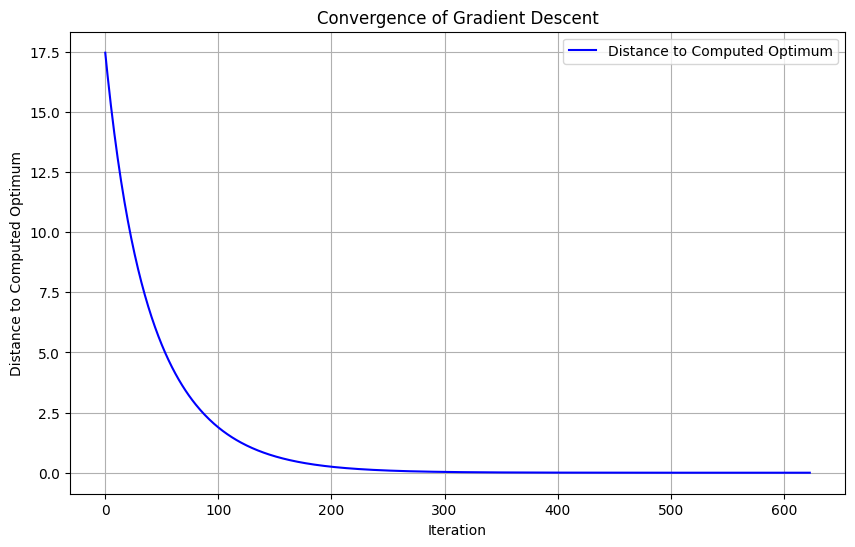

Converged in 641 iterations.
Computed optimum using gradient descent: [0.         0.         0.25002485]
f(x) at computed optimum: -0.12499999876446624
Final value of alpha = 0.005


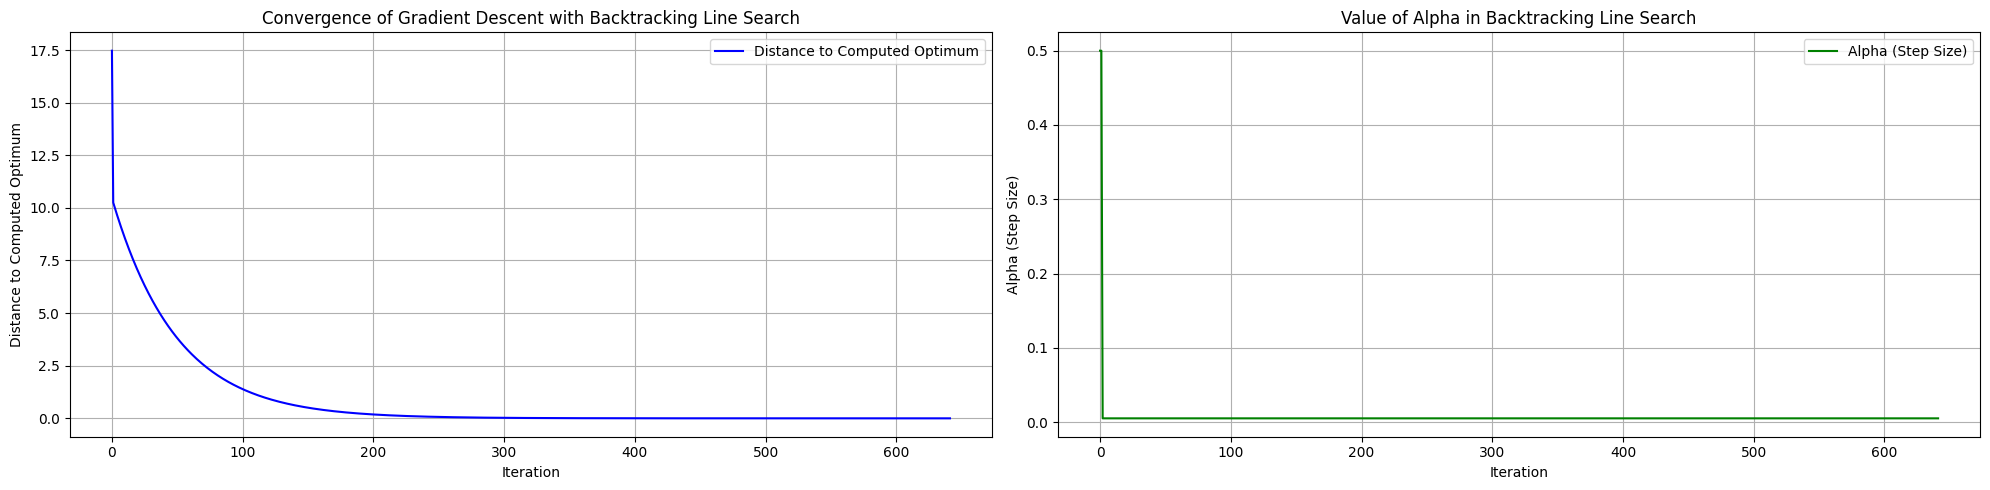

Converged in 1 iterations.
Computed optimum using Newton's method: [-1.0000889e-11  0.0000000e+00  2.5000000e-01]
f(x) at computed optimum: -0.125
Final value of alpha = 1.0


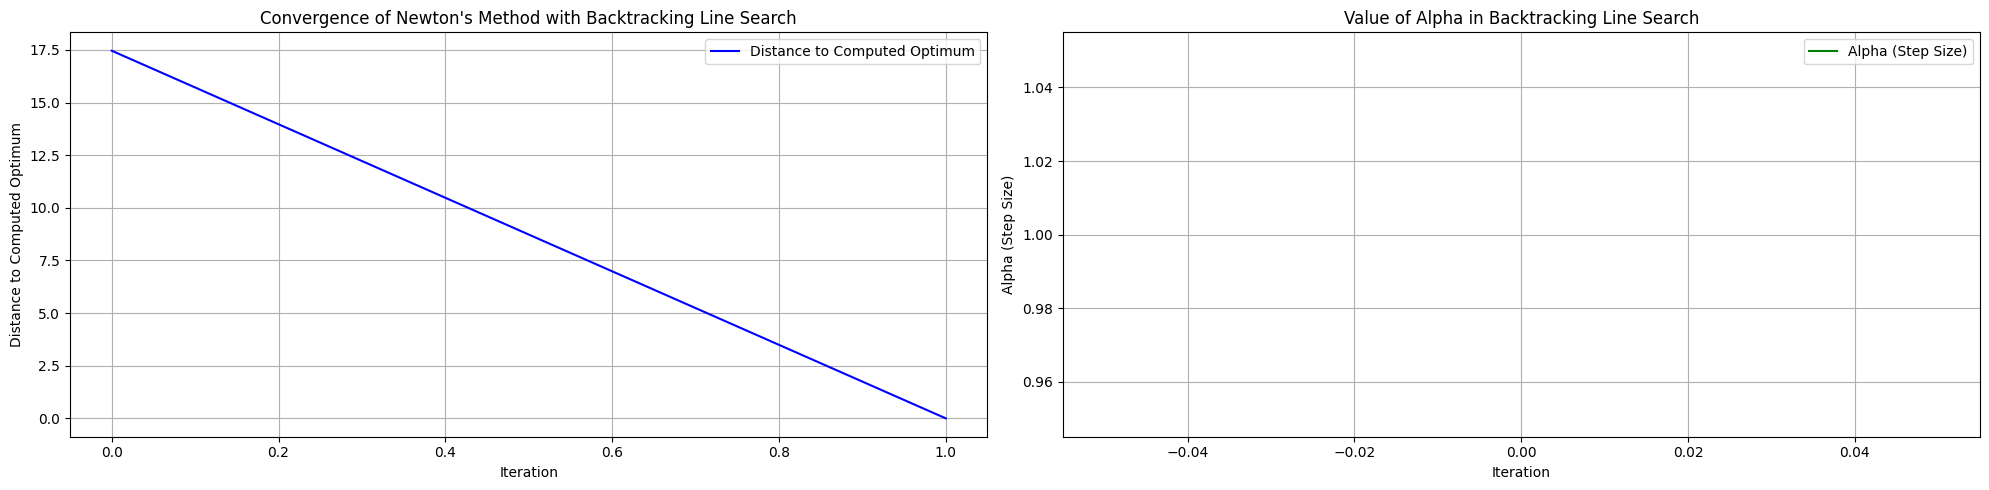

In [81]:
def f4(x):
    """Objective function f(x) = 0.5 * [x y z] * [1 1 0; 1 1 0; 0 0 4] * [x; y; z] - [0 0 1] * [x; y; z]"""
    return 0.5 * np.dot(x.T, np.dot(np.array([[1, 1, 0], [1, 1, 0], [0, 0, 4]]), x)) - np.dot(np.array([0, 0, 1]), x)


def f4_gradient(x):
    """Gradient of the objective function f(x)"""
    return np.array([x[0] + x[1], x[0] + x[1], 4 * x[2] - 1])


def f4_hessian(x):
    """Hessian of the objective function f(x)"""
    return np.array([[1, 1, 0], [1, 1, 0], [0, 0, 4]])


# Call the function to compute the local minima using Gradient Descent Without Backtracking Line Search and Plot
gd_wo_bls(f=f4, f_grad=f4_gradient, x0=np.array(
    [-10, -10, -10]), alpha=0.01)

# Call the function to compute the local minima using Gradient Descent With Backtracking Line Search and Plot
gd_w_bls(f=f4, f_grad=f4_gradient, x0=np.array(
    [-10, -10, -10]), alpha_init=0.5, rho=0.01)

# Call the function to compute the local minima using Newton's Method With Backtracking Line Search and Plot
nm_w_bls(f=f4, f_grad=f4_gradient, f_hess=f4_hessian,
         x0=np.array([-10, -10, -10]), alpha_init=1.0, rho=0.5, gamma=(1e-12 * np.eye(3)))